# Multiomics BRDC Paper — Figure 4

This Jupyter Notebook (with Python 3 kernel) contained the code of the proteogenomic analysis between DCIS_Pure and DCIS_Pro.

Input files:  
* The clinical file: clinical.csv
* The gene location file: gene_loc.csv
* The copy number file: cnv.csv
* The gene copy number file: gcnv.csv
* The proteome file: pro.csv
* The proteome-based ssGSEA score: pscore.csv
* The phosphoproteome-based ssGSEA score: phoscore.csv

Output figures and tables:  
* Figure 4A, 4B, 4C, 4D, 4E, 4F, 4G, 4H, 4I, 4J, and 4L
* Supplementary Table 5A, 

In [29]:
from brdc_utils import *

import warnings
warnings.filterwarnings("ignore")

In [30]:
outpaths = ['../figure/fig4', '../documents/fig4']
for outpath in outpaths:
    if not os.path.isdir(outpath):
        os.mkdir(outpath)

clinical = pd.read_csv('../document/clinical.csv', index_col=0)
cnv = pd.read_csv('../document/cnv.csv', index_col=0)
gcnv = pd.read_csv('../document/gcnv.csv', index_col=0)
gene_loc = pd.read_csv('../document/gene_loc.csv', index_col=0)
pro = pd.read_csv('../document/proteome.csv', index_col=0)
pscore = pd.read_csv('../document/pscore.csv', index_col=0)
phoscore = pd.read_csv('../document/phoscore.csv', index_col=0)

order_ = ['DCIS_Pure', 'DCIS_Pro']
palette = ['#e47cae', '#d22362']

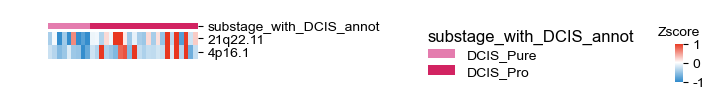

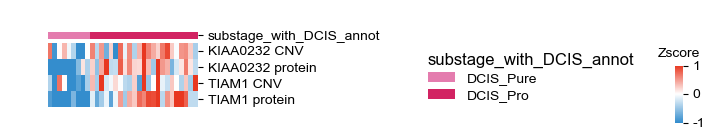

In [31]:
# Figure 4A (top panel), Supplementary_Table_5A

from collections import defaultdict

dcis_arm = combine(clinical, cnv, 'substage_with_DCIS_annot', part_element=['DCIS_Pure', 'DCIS_Pro']).droplevel(0)
table = group_table(dcis_arm, prestatistic_method=None)
arm = table.query("(DCIS_Pro_vs_DCIS_Pure>0)&(ranksums<0.05)&(DCIS_Pro>0.1)").sort_values('ranksums').index
genes = np.intersect1d(pro.index, gene_loc.loc[arm])

dcis_pro = combine(clinical, pro, 'substage_with_DCIS_annot', part_element=['DCIS_Pure', 'DCIS_Pro']).T
dcis_gcnv = combine(clinical, gcnv, 'substage_with_DCIS_annot', part_element=['DCIS_Pure', 'DCIS_Pro']).T

corr_out = defaultdict(dict)
for gene in genes:
    *_, rho, prob = correlation(dcis_pro.droplevel(1, 1).loc[gene], dcis_gcnv.droplevel(1, 1).loc[gene])
    corr_out[gene]['spearman rho'] = rho
    corr_out[gene]['spearman prob'] = prob

corr_df = pd.DataFrame().from_dict(corr_out, orient='index').sort_values('spearman prob')
genes = corr_df.query("(`spearman prob`<0.05)&(`spearman rho`>0)").index

pro_table = group_table(dcis_pro.T.droplevel(0))
gcnv_table = group_table(dcis_gcnv.T.droplevel(0), prestatistic_method=None)

genes = pro_table.loc[genes].query("(DCIS_Pro_vs_DCIS_Pure>1)&(ttest_fdr<0.05)").index
genes = gcnv_table.loc[genes].query("(DCIS_Pro_vs_DCIS_Pure>0)&(ttest<0.05)").index

import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list("blue_red_gradient", ['#348dcd', 'white', '#e83720'], N=256)

ax = heatmap(dcis_arm[arm].T.sort_index(axis=1, ascending=False), lut={'substage_with_DCIS_annot': dict(zip(order_, palette))}, z_score=0, figsize=(4, 1), colors_ratio=0.15, cmap=cmap, cbar_pos=(1.7, .15, .02, .38))
ax.ax_cbar.set_title('Zscore', fontsize=10)
ax.savefig('../figure/fig4/figure4A_top-panel_arm_heatmap.pdf', bbox_inches='tight')

plotdata = pd.concat([dcis_pro.loc[genes].rename(index=lambda x: x + ' protein'), dcis_gcnv.loc[genes].rename(index=lambda x: x + ' CNV')], join='inner').sort_index().sort_index(level=1, axis=1, ascending=False)
ax = heatmap(plotdata, lut={'substage_with_DCIS_annot': dict(zip(order_, palette))}, z_score=0, figsize=(4, 1.5), colors_ratio=0.08, cmap=cmap, cbar_pos=(1.7, .15, .02, .38))
ax.ax_cbar.set_title('Zscore', fontsize=10)
ax.savefig('../figure/fig4/figure4A_top-panel_gene_heatmap.pdf', bbox_inches='tight')

out_table = pro_table.iloc[:, [0, 1, 2, 4, 6]]
out_table.columns = ['DCIS_Pro mean value',	'DCIS_Pure mean value',	'FC(DCIS_Pro vs DCIS_Pure)', 'ranksums p value', 'adjusted ranksums p value']
out_table.to_csv('../documents/fig4/Supplementary_Table_5A.csv')

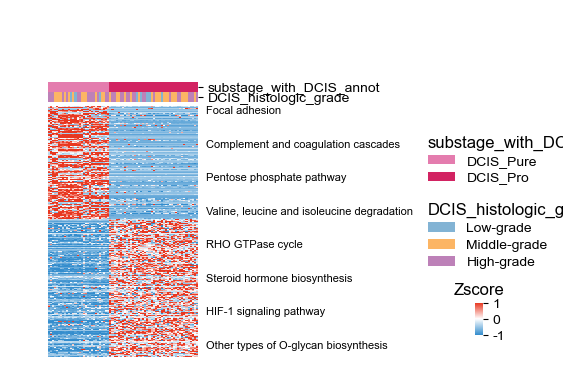

In [32]:
# Figure 4A (middle panel)

dcis_ora = pd.read_csv('../document/dcis_proteome_ORA.csv', index_col=0)
genes = dcis_ora['members_input_overlap'].str.split('; ').explode().values.tolist()[::-1]
plotdata = combine(clinical, pro, ['substage_with_DCIS_annot', 'DCIS_histologic_grade'], genes, part_element={'substage_with_DCIS_annot': ['DCIS_Pure', 'DCIS_Pro']}).T.rename_axis(['Exp', 'substage_with_DCIS_annot', 'DCIS_histologic_grade'], axis=1).sort_index(level=[1, 0], axis=1, ascending=[False, False])
fig = heatmap(plotdata, lut={'substage_with_DCIS_annot': dict(zip(order_, palette)), 'DCIS_histologic_grade': {'Low-grade': '#82b3d4', 'Middle-grade': '#fcb564', 'High-grade': '#bd81b8'}}, yticklabels=False, z_score=0, cmap=cmap, colors_ratio=.03, cbar_pos=(1.2, .15, .02, .08))
fig.ax_cbar.set_title('Zscore')

ax = fig.ax_heatmap
ylim = ax.get_ylim()[0]
for i, t in enumerate(zip(np.linspace(10, ylim-10, 8), dcis_ora['gene set'].str.split(' - ', expand=True)[0].values[::-1])):
    pos, annot = t
    ax.text(77, pos, annot, fontsize=8)

fig.savefig('../figure/fig4/figure4A_middle-panel_heatmap.pdf', bbox_inches='tight')

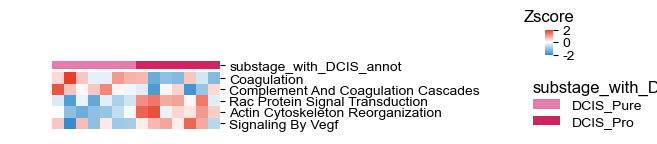

In [33]:
# Figure 4A (bottom panel)

pathways = ['HALLMARK_COAGULATION', 'KEGG_COMPLEMENT_AND_COAGULATION_CASCADES', 'GOBP_RAC_PROTEIN_SIGNAL_TRANSDUCTION', 'GOBP_ACTIN_CYTOSKELETON_REORGANIZATION', 'REACTOME_SIGNALING_BY_VEGF']
plotdata = combine(clinical, phoscore, 'substage_with_DCIS_annot', pathways, part_element=['DCIS_Pure', 'DCIS_Pro']).T.sort_index(level=1, axis=1, ascending=False)
fig = heatmap(plotdata, lut={'substage_with_DCIS_annot': dict(zip(order_, palette))}, z_score=0, cmap=cmap, vmax=2, vmin=-2, figsize=(5, 1.4), colors_ratio=.1, cbar_pos=(1.1, .8, .015, .18), yticklabels=list(map(lambda x: x.split('_', 1)[1].replace('_', ' ').title(), plotdata.index)))
fig.ax_cbar.set_title('Zscore')
fig.savefig('../figure/fig4/figure4A_bottom_heatmap.pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


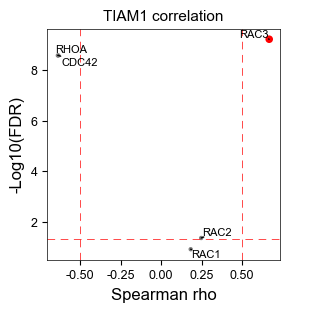

In [34]:
# Figure 4B

from collections import defaultdict

clinical_samples = clinical.query("substage_with_DCIS_annot in ['DCIS_Pure', 'DCIS_Pro']").index
samples = np.intersect1d(clinical_samples, pro.columns)
genes = ['RAC1', 'RAC2', 'RAC3', 'RHOA', 'CDC42']
dcis_pro = pro[samples]

corr_out = defaultdict(dict)
for gene in dcis_pro.index:
    *_, rho, prob = correlation(dcis_pro.loc['TIAM1'], dcis_pro.loc[gene])
    corr_out[gene]['spearman rho'] = rho
    corr_out[gene]['spearman prob'] = prob
plotdata = pd.DataFrame().from_dict(corr_out, orient='index').sort_values('spearman prob').loc[genes]
plotdata['spearman FDR'] = fdr(plotdata.iloc[:, 1])[1]
plotdata.loc['RAC3', 'annot'] = 'highlight'
plotdata.loc[:, 'annot'] = plotdata.loc[:, 'annot'].fillna('others')
plotdata.iloc[:, 2] = -np.log10(plotdata.iloc[:, 2])
plotdata.columns = 'Spearman rho', '', '-Log10(FDR)', 'annot'

ax = scatterplot(plotdata.iloc[:, [0, 3, 2]], sizes=(30, 10), palette=['grey', 'red'], highlight_points=genes, ticklabels_format=[], ticklabels_hide=[], spines_hide=[], title='TIAM1 correlation', legend=False)
ax.axhline(y=-np.log10(0.05), c="red", ls="--", dashes=(11, 8), lw=0.5)
for i in [.5, -.5]:
    ax.axvline(x=i, c="red", ls="--", dashes=(11, 8), lw=0.5)

ax.get_figure().savefig('../figure/fig4/figure4B_scatterplot.pdf', bbox_inches='tight')

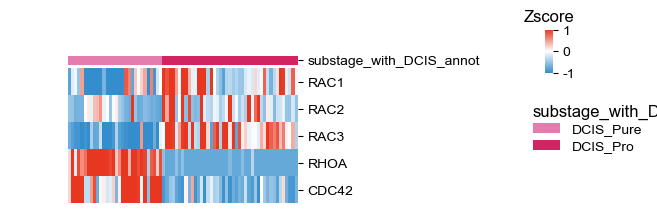

In [35]:
# Figure 4C

plotdata = combine(clinical, pro, 'substage_with_DCIS_annot', genes, part_element=['DCIS_Pure', 'DCIS_Pro']).T.sort_index(level=1, axis=1, ascending=False)
fig = heatmap(plotdata, lut={'substage_with_DCIS_annot': dict(zip(order_, palette))}, z_score=0, cmap=cmap, vmax=1, vmin=-1, figsize=(5, 2.4), colors_ratio=.05, cbar_pos=(1.1, .7, .015, .18))
fig.ax_cbar.set_title('Zscore')
fig.savefig('../figure/fig4/figure4C_heatmap.pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


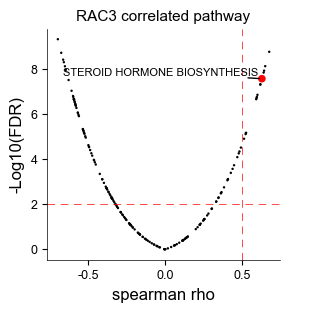

In [36]:
# Figure 4D

tmp = combine(clinical, pro, 'substage_with_DCIS_annot', 'RAC3', how='inner', part_element=['DCIS_Pure', 'DCIS_Pro'])

table = pscore.apply(correlation, y=tmp.droplevel(1), axis=1, result_type='expand')
table.columns = 'pearson corr', 'pearson prob', 'spearman rho', 'spearman prob'
table['spearman fdr'] = fdr(table['spearman prob'])[1]
plotdata = table.filter(like='KEGG', axis=0).sort_values('spearman prob')[['spearman rho', 'spearman fdr']]

plotdata.iloc[:, 1] = -np.log10(plotdata.iloc[:, 1])
plotdata.loc['KEGG_STEROID_HORMONE_BIOSYNTHESIS', 'annot'] = 'annotated'
plotdata.loc[:, 'annot'] = plotdata.loc[:, 'annot'].fillna('others')
plotdata['size'] = plotdata['annot']
ax = scatterplot(plotdata.iloc[:, [0, 2, 1]], highlight_points=['KEGG_STEROID_HORMONE_BIOSYNTHESIS'], title='RAC3 correlated pathway', palette=['black', 'red'], sizes=[3, 30], ticklabels_format=[], ticklabels_hide=[], legend=False)
ax.set_ylabel('-Log10(FDR)')
ax.axhline(y=-np.log10(0.01), c="red", ls="--", dashes=(11, 8), lw=0.5)
ax.axvline(x=.5, c="red", ls="--", dashes=(11, 8), lw=0.5)

ax.get_figure().savefig('../figure/fig4/figure4D_scatterplot.pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


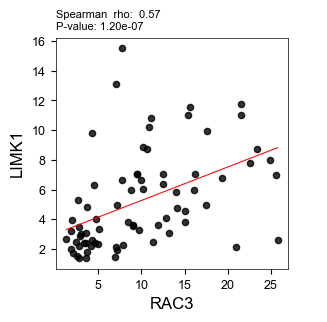

In [37]:
# Figure 4E

plotdata = pro.loc[['RAC3', 'LIMK1'], samples].T
ax = regplot(plotdata, ci=0)
ax.get_figure().savefig('../figure/fig4/figure4E_regplot.pdf', bbox_inches='tight')

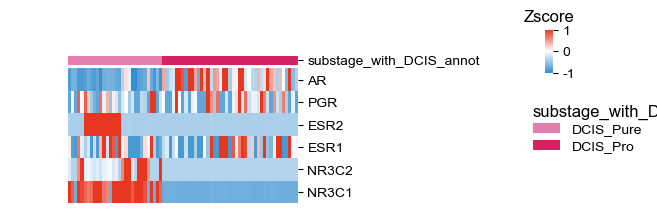

In [38]:
# Figure 4F

plotdata = combine(clinical, pro, 'substage_with_DCIS_annot', ['AR', 'PGR', 'ESR2', 'ESR1', 'NR3C2', 'NR3C1'], part_element=['DCIS_Pure', 'DCIS_Pro']).T.sort_index(level=1, axis=1, ascending=False)
fig = heatmap(plotdata, lut={'substage_with_DCIS_annot': dict(zip(order_, palette))}, z_score=0, cmap=cmap, vmax=1, vmin=-1, figsize=(5, 2.4), colors_ratio=.05, cbar_pos=(1.1, .7, .015, .18))
fig.ax_cbar.set_title('Zscore')
fig.savefig('../figure/fig4/figure4F_heatmap.pdf', bbox_inches='tight')

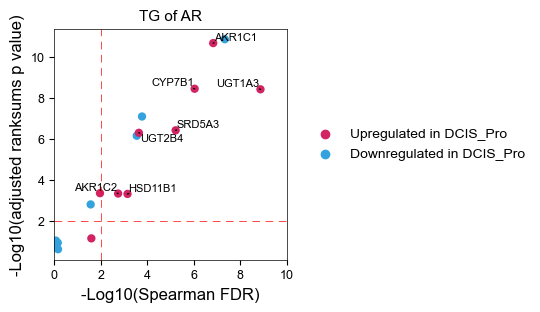

In [39]:
# Figure 4G, Supplementary_Table_5C

at_target_steroid_genes = ['SRD5A3', 'CYP3A5', 'COMT', 'CYP7A1', 'AKR1C3', 'HSD11B1', 'HSD17B1', 'CYP19A1', 'UGT1A3', 'UGT1A10', 'AKR1C2', 'AKR1C1', 'CYP1A1', 'STS', 'UGT2A1', 'SRD5A2', 'CYP7B1', 'UGT2B4', 'UGT2B17', 'UGT2B15']

ar_corr_table = dcis_pro.apply(correlation, y=dcis_pro.loc['AR'], axis=1, result_type='expand')
ar_corr_table.columns = 'pearson corr', 'pearson prob', 'spearman rho', 'spearman prob'
ar_corr_table.loc[:, 'spearman FDR'] = fdr(ar_corr_table.loc[:, 'spearman prob'])[1]
out_table = pd.concat([pro_table.reindex(at_target_steroid_genes).dropna()[['DCIS_Pro_vs_DCIS_Pure', 'ranksums_fdr']], ar_corr_table[['spearman rho', 'spearman FDR']]], axis=1, join='inner').rename_axis('Gene Symbol')

plotdata = out_table.iloc[:, [0, 1, -1]]
plotdata['-Log10(Spearman FDR)'] = -np.log10(plotdata['spearman FDR'])
plotdata['annot'] = plotdata['DCIS_Pro_vs_DCIS_Pure'].apply(lambda x: 'Upregulated in DCIS_Pro' if x > 1 else 'Downregulated in DCIS_Pro')
plotdata['-Log10(adjusted ranksums p value)'] = -np.log10(plotdata['ranksums_fdr'])
ax = scatterplot(plotdata.iloc[:, 3:], palette=['#d22362', '#34a3dd'], ticklabels_format=[], ticklabels_hide=[], highlight_points=['AKR1C1', 'UGT1A3', 'CYP7B1', 'SRD5A3', 'UGT2B4', 'AKR1C2', 'HSD11B1'], title='TG of AR', spines_hide=[])
ax.set_xlim([0, 10])
ax.axhline(y=-np.log10(0.01), c="red", ls="--", dashes=(11, 8), lw=0.5)
ax.axvline(x=-np.log10(0.01), c="red", ls="--", dashes=(11, 8), lw=0.5)
ax.get_figure().savefig('../figure/fig4/figure4G_scatterplot.pdf', bbox_inches='tight')

out_table.columns = 'FC(DCIS_Pro vs DCIS_Pure)', 'adjusted ranksums p value', 'spearman rho', 'spearman FDR'
out_table.to_csv('../documents/fig4/Supplementary_Table_5C.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


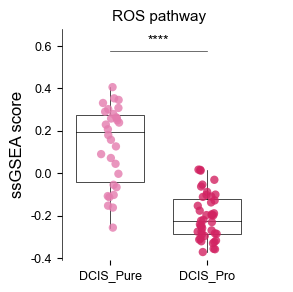

In [40]:
# Figure 4H

plotdata = combine(clinical, pscore, 'substage_with_DCIS_annot', ['HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY'], part_element=['DCIS_Pure', 'DCIS_Pro']).sort_index(level=1, axis=0, ascending=False).droplevel(0)
ax = cateplot(plotdata, ticklabels_format=[], palette=palette, labels_hide=['x'], title='ROS pathway', log_transform='no')
ax.set_ylabel('ssGSEA score')
ax.get_figure().savefig('../figure/fig4/figure4H_cateplot.pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


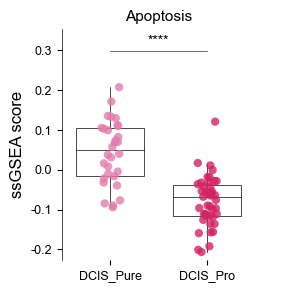

In [41]:
# Figure 4I

plotdata = combine(clinical, pscore, 'substage_with_DCIS_annot', ['HALLMARK_APOPTOSIS'], part_element=['DCIS_Pure', 'DCIS_Pro']).sort_index(level=1, axis=0, ascending=False).droplevel(0)
ax = cateplot(plotdata, ticklabels_format=[], palette=palette, labels_hide=['x'], title='Apoptosis', log_transform='no')
ax.set_ylabel('ssGSEA score')
ax.get_figure().savefig('../figure/fig4/figure4I_cateplot.pdf', bbox_inches='tight')

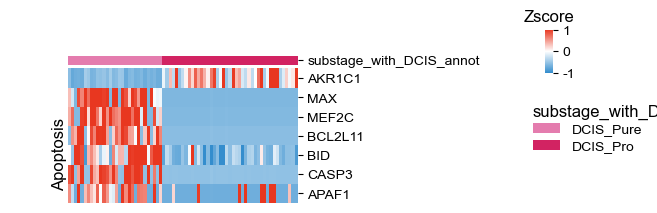

In [42]:
# Figure 4J

plotdata = combine(clinical, pro, 'substage_with_DCIS_annot', ['AKR1C1', 'MAX', 'MEF2C', 'BCL2L11', 'BID', 'CASP3', 'APAF1'], part_element=['DCIS_Pure', 'DCIS_Pro']).T.sort_index(level=1, axis=1, ascending=False)
fig = heatmap(plotdata, lut={'substage_with_DCIS_annot': dict(zip(order_, palette))}, z_score=0, cmap=cmap, vmax=1, vmin=-1, figsize=(5, 2.4), colors_ratio=.05, cbar_pos=(1.1, .7, .015, .18))
fig.ax_cbar.set_title('Zscore')
ax = fig.ax_heatmap
ax.text(-5, 6.2, 'Apoptosis', fontsize=12, rotation='vertical')
fig.savefig('../figure/fig4/figure4J_heatmap.pdf', bbox_inches='tight')

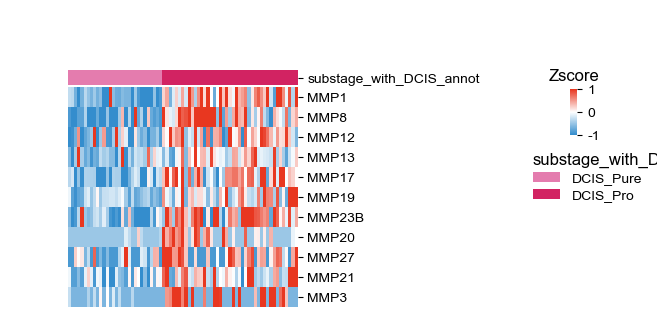

In [43]:
# Figure 4L

genes = ['MMP1', 'MMP8', 'MMP12', 'MMP13', 'MMP17', 'MMP19', 'MMP23B', 'MMP20', 'MMP27', 'MMP21', 'MMP3']
plotdata = combine(clinical, pro, 'substage_with_DCIS_annot', genes, part_element=['DCIS_Pure', 'DCIS_Pro']).T.sort_index(level=1, axis=1, ascending=False)
fig = heatmap(plotdata, lut={'substage_with_DCIS_annot': dict(zip(order_, palette))}, z_score=0, cmap=cmap, vmax=1, vmin=-1, figsize=(5, 3.5), colors_ratio=.05, cbar_pos=(1.15, .6, .015, .13))
fig.ax_cbar.set_title('Zscore')
fig.savefig('../figure/fig4/figure4L_heatmap.pdf', bbox_inches='tight')